# Multi-task Neural network

In [201]:
import os
import torch
from torch import nn
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

from mm_survival.pipelines import run_survival_analysis

In [123]:
tpm_rna_filename = 'data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv'
count_rna_file = 'data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_Counts.txt'
clinical_file = 'data/clinical/sc3_Training_ClinAnnotations.csv'
DE_genes_filename = 'data/gene_expression/differential_expression/DE_genes.txt'
signature_genes_filename = 'data/gene_expression/differential_expression/signature_genes.txt'

inputs = run_survival_analysis(tpm_rna_filename, count_rna_file, clinical_file,
            DE_genes_filename, signature_genes_filename, 'RF', 200, top_k_genes=100)

X, y, y_os, y_pfs = inputs

X.shape, y.shape

We have 57997 genes in the raw counts gene expression matrix
We have 24128 genes in the TPM normalized gene expression matrix
N° of patients in the MMRF cohort, with RNAseq available RNA-seq data: 735
N° of patients in the MMRF cohort, with RNAseq available TPM-normalized RNA-seq data: 735
Number of patients with clinical and sequencing data: 582
Total number of genes in the dataset: 100
(391, 102)


((391, 102), (391,))

**Import the prepared data**

In [162]:
class MLP(nn.Module):
    '''
        Multi-layer perceptron
    '''
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(102, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            # NO SOFTMAX HERE PYTORCH nn.CrossEntropyLoss() EXPECTS RAW LOGITS !!!
        )
        
        #self.model.apply(weights_init_normal)
    
    def forward(self, x):
        '''
            Forward pass
        '''
        return torch.sigmoid(self.model(x))

In [187]:
import pdb

def train_model(model, train_loader, valid_loader, history, epochs, optimizer, lr_scheduler):
    """
    :param: model: Pytorch model to be trained
    :param: train_loader: train dataloader (torch.utils.data.Dataloader object)
    :param: valid_loader: validation dataloader (torch.utils.data.Dataloader object)
    :param: history: dictionnary where learning curves are stored
    :param: epochs: number of epochs
    :param: optimizer: torch.optim object
    :param: lr_scheduler: learning rate scheduler
    :param: clipping: Whether to use gradient clipping (for RNN)
    :return: None
    """
    model.train() # Ensure the network is in "train" mode with dropouts active
    accs = []
    aucs = []
    for e in range(epochs):
        running_loss, running_accuracy = 0, 0
        for x, labels in train_loader:
            x = x.to(device)
            labels = labels.float().to(device)
            # Forward Pass
            optimizer.zero_grad()
            output = model(x).flatten()
            #pdb.set_trace()
            loss = criterion(output, labels)
            # Backward Pass
            loss.backward() 
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += compute_accuracy(output, labels)
        else:
            validation_loss, validation_acc, validation_auc = eval_model(model, valid_loader)
            
            model.train()

            lr_scheduler.step(validation_loss)

            train_loss = running_loss / len(train_loader)
            train_accuracy = running_accuracy / len(train_loader)
            
            history['train_loss'].append(train_loss), history['train_acc'].append(train_accuracy)
            history['valid_loss'].append(validation_loss), history['valid_acc'].append(validation_acc)

            if (e+1)%1 == 0:
                #pdb.set_trace()
                print("Epoch {}: Training loss: {} | Training accuracy: {}".format(e+1, train_loss, train_accuracy))
                print("Epoch {}: Validation loss: {} | Validation accuracy: {} | Validation AUC: {}".format(e+1,
                                                                                                            validation_loss,
                                                                                                            validation_acc,
                                                                                                           validation_auc))
                print()
    return model

In [188]:
def compute_accuracy(probs, labels):
    """
    :param: probs: inferred probabiliy
    :param: labels: groundtruth binary labels
    :return: accuracy metric
    """
    preds = (probs > 0.5).int()
    accuracy = (preds == labels).float()
    accuracy = torch.mean(accuracy)
    return accuracy

def compute_auc(probs, labels):
    """
    :param: probs: inferred probabiliy
    :param: labels: groundtruth binary labels
    :return:
    """
    preds = (probs > 0.5).int()
    #pdb.set_trace()
    fpr, tpr, _ = roc_curve(preds, labels)
    auc_score = auc(fpr, tpr)
    return auc_score

def eval_model(model, dataloader):
    """
    :param: model: Pytorch model to evaluate
    :param: dataloader: torch.utils.data.Dataloader object
    :return: Validation loss and Accuracy
    """
    model.eval()
    eval_loss, eval_acc, eval_auc = 0, 0, 0
    for x, labels in dataloader:
        x = x.to(device)
        labels = labels.float().to(device)
        output = model(x).flatten()
        loss = criterion(output, labels)
        eval_loss += loss.item()
        eval_acc += compute_accuracy(output, labels)
        eval_auc += compute_auc(output, labels)
        
    return eval_loss / len(dataloader), eval_acc / len(dataloader), eval_auc /len(dataloader)

In [196]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((312, 102), (79, 102), (312,), (79,))

In [219]:
model = MLP()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = {'train_loss': [], 'valid_loss': [],
          'train_acc': [], 'valid_acc': []
          }

epochs = 50
learning_rate = 1e-3
batch_size = 100

# Binary Cross-Entropy
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=0.001)
lr_scheduler = ReduceLROnPlateau(optimizer)

# criterion
#criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=0.001)
#lr_scheduler = ReduceLROnPlateau(optimizer)

#train_model(model, train_loader, valid_loader, history, epochs, optimizer, lr_scheduler)

**Train**

In [229]:
k = 5
kfold = KFold(n_splits=5)
kfold = KFold(n_splits=5)

kfold.get_n_splits(X)

mean_acc = 0
mean_auc = 0
N = 10


for train_index, valid_index in kfold.split(X):
    model = MLP()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=0.001)
    lr_scheduler = ReduceLROnPlateau(optimizer)

    X_train, X_valid = X[train_index, :], X[valid_index, :]
    y_train, y_valid = y[train_index], y[valid_index]

    print(X_train.shape, X_valid.shape)

    train_dataset = TensorDataset(torch.Tensor(X_train),
                       torch.tensor(y_train)
                       )

    valid_dataset = TensorDataset(torch.Tensor(X_valid),
                           torch.tensor(y_valid)
                           )

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

    model = train_model(model, train_loader, valid_loader, history, epochs, optimizer, lr_scheduler)
    _, validation_acc, validation_auc = eval_model(model, valid_loader)

    mean_acc += validation_acc
    if validation_auc != np.nan:
        mean_auc += validation_auc

(312, 102) (79, 102)
Epoch 1: Training loss: 0.7324101775884628 | Training accuracy: 0.5550000071525574
Epoch 1: Validation loss: 0.730679988861084 | Validation accuracy: 0.27848100662231445 | Validation AUC: nan

Epoch 2: Training loss: 0.7372737526893616 | Training accuracy: 0.44583335518836975
Epoch 2: Validation loss: 0.7329427003860474 | Validation accuracy: 0.27848100662231445 | Validation AUC: nan

Epoch 3: Training loss: 0.7366167455911636 | Training accuracy: 0.5166666507720947
Epoch 3: Validation loss: 0.7274891138076782 | Validation accuracy: 0.29113924503326416 | Validation AUC: 0.641025641025641

Epoch 4: Training loss: 0.7541067898273468 | Training accuracy: 0.4658333361148834
Epoch 4: Validation loss: 0.722368061542511 | Validation accuracy: 0.3544303774833679 | Validation AUC: 0.6506849315068493

Epoch 5: Training loss: 0.7131654024124146 | Training accuracy: 0.5216666460037231
Epoch 5: Validation loss: 0.7226810455322266 | Validation accuracy: 0.4556961953639984 | Vali

//anaconda3/envs/owkin/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
//anaconda3/envs/owkin/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


Epoch 16: Training loss: 0.5968819856643677 | Training accuracy: 0.7008333206176758
Epoch 16: Validation loss: 0.6207276582717896 | Validation accuracy: 0.6835442781448364 | Validation AUC: 0.5849146110056925

Epoch 17: Training loss: 0.6166545152664185 | Training accuracy: 0.6949999928474426
Epoch 17: Validation loss: 0.6180984377861023 | Validation accuracy: 0.6835442781448364 | Validation AUC: 0.593859649122807

Epoch 18: Training loss: 0.6067424267530441 | Training accuracy: 0.6949999928474426
Epoch 18: Validation loss: 0.6179121136665344 | Validation accuracy: 0.6835442781448364 | Validation AUC: 0.602216748768473

Epoch 19: Training loss: 0.6066389828920364 | Training accuracy: 0.7108333110809326
Epoch 19: Validation loss: 0.6194471716880798 | Validation accuracy: 0.6835442781448364 | Validation AUC: 0.602216748768473

Epoch 20: Training loss: 0.5748753324151039 | Training accuracy: 0.7099999785423279
Epoch 20: Validation loss: 0.6116039752960205 | Validation accuracy: 0.69620251

Epoch 24: Training loss: 0.6066340059041977 | Training accuracy: 0.6863461136817932
Epoch 24: Validation loss: 0.6009381413459778 | Validation accuracy: 0.7051281929016113 | Validation AUC: 0.5347222222222222

Epoch 25: Training loss: 0.6214306950569153 | Training accuracy: 0.6746153831481934
Epoch 25: Validation loss: 0.5978605151176453 | Validation accuracy: 0.7051281929016113 | Validation AUC: 0.5347222222222222

Epoch 26: Training loss: 0.5939132571220398 | Training accuracy: 0.6955769658088684
Epoch 26: Validation loss: 0.5962613821029663 | Validation accuracy: 0.7051281929016113 | Validation AUC: 0.5589285714285714

Epoch 27: Training loss: 0.5889173150062561 | Training accuracy: 0.7305769324302673
Epoch 27: Validation loss: 0.5914583802223206 | Validation accuracy: 0.7179487347602844 | Validation AUC: 0.5875251509054327

Epoch 28: Training loss: 0.5546651482582092 | Training accuracy: 0.7230769395828247
Epoch 28: Validation loss: 0.5867369174957275 | Validation accuracy: 0.71794

Epoch 31: Training loss: 0.5538503080606461 | Training accuracy: 0.7540384531021118
Epoch 31: Validation loss: 0.5983471274375916 | Validation accuracy: 0.7435897588729858 | Validation AUC: 0.7042410714285714

Epoch 32: Training loss: 0.6071437150239944 | Training accuracy: 0.7180769443511963
Epoch 32: Validation loss: 0.5897972583770752 | Validation accuracy: 0.7435897588729858 | Validation AUC: 0.7042410714285714

Epoch 33: Training loss: 0.6022545397281647 | Training accuracy: 0.6855769157409668
Epoch 33: Validation loss: 0.5877702832221985 | Validation accuracy: 0.7435897588729858 | Validation AUC: 0.7042410714285714

Epoch 34: Training loss: 0.6496060788631439 | Training accuracy: 0.6805769205093384
Epoch 34: Validation loss: 0.5864125490188599 | Validation accuracy: 0.7564102411270142 | Validation AUC: 0.7307692307692306

Epoch 35: Training loss: 0.5900398641824722 | Training accuracy: 0.6963461637496948
Epoch 35: Validation loss: 0.5874673128128052 | Validation accuracy: 0.74358

Epoch 39: Training loss: 0.5932922065258026 | Training accuracy: 0.7173076868057251
Epoch 39: Validation loss: 0.5868008136749268 | Validation accuracy: 0.7692307829856873 | Validation AUC: 0.5997983870967742

Epoch 40: Training loss: 0.5951022356748581 | Training accuracy: 0.7063461542129517
Epoch 40: Validation loss: 0.581693172454834 | Validation accuracy: 0.7692307829856873 | Validation AUC: 0.5997983870967742

Epoch 41: Training loss: 0.6511552333831787 | Training accuracy: 0.6728846430778503
Epoch 41: Validation loss: 0.596431314945221 | Validation accuracy: 0.7692307829856873 | Validation AUC: 0.5997983870967742

Epoch 42: Training loss: 0.5278138518333435 | Training accuracy: 0.742307722568512
Epoch 42: Validation loss: 0.5899937748908997 | Validation accuracy: 0.7692307829856873 | Validation AUC: 0.5997983870967742

Epoch 43: Training loss: 0.5655518174171448 | Training accuracy: 0.7205769419670105
Epoch 43: Validation loss: 0.5786556005477905 | Validation accuracy: 0.76923078

//anaconda3/envs/owkin/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


Epoch 8: Training loss: 0.6556191742420197 | Training accuracy: 0.6121153831481934
Epoch 8: Validation loss: 0.670933187007904 | Validation accuracy: 0.5 | Validation AUC: 0.5982758620689655

Epoch 9: Training loss: 0.6501737534999847 | Training accuracy: 0.6413461565971375
Epoch 9: Validation loss: 0.664118230342865 | Validation accuracy: 0.5641025900840759 | Validation AUC: 0.6369811320754717

Epoch 10: Training loss: 0.6590946912765503 | Training accuracy: 0.6028846502304077
Epoch 10: Validation loss: 0.656622588634491 | Validation accuracy: 0.5641025900840759 | Validation AUC: 0.6369811320754717

Epoch 11: Training loss: 0.6626202911138535 | Training accuracy: 0.6538461446762085
Epoch 11: Validation loss: 0.6538477540016174 | Validation accuracy: 0.5641025900840759 | Validation AUC: 0.6369811320754717

Epoch 12: Training loss: 0.6148295998573303 | Training accuracy: 0.7073076963424683
Epoch 12: Validation loss: 0.6599381566047668 | Validation accuracy: 0.5384615659713745 | Validati

In [233]:
print("Mean accuracy: {} | Mean AUC:  {}".format(mean_acc/(k), mean_auc/(k)))

Mean accuracy: 0.7058098316192627 | Mean AUC:  0.6620271260997067


Text(0.5, 1.0, 'Learning curves')

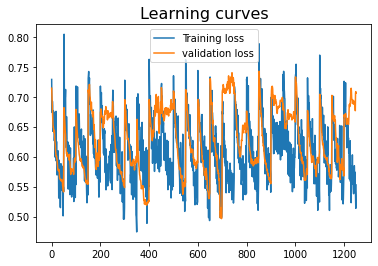

In [231]:
plt.plot(history['train_loss'], label='Training loss'), plt.plot(history['valid_loss'], label='validation loss')
plt.legend()
plt.title('Learning curves', fontsize=16)

Text(0.5, 1.0, 'Training/Validation Accuracy')

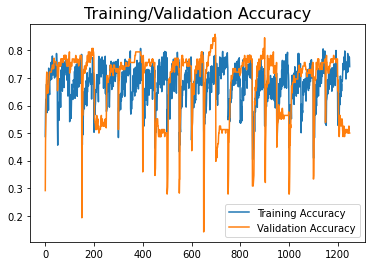

In [232]:
plt.plot(history['train_acc'], label='Training Accuracy'), plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Training/Validation Accuracy', fontsize=16)